In [1]:
%matplotlib inline


# Multiway Cluster Robust DML

This example shows how the multiway cluster roboust DML (Chiang et al. 2020) can be implemented with the DoubleML
package.
Chiang et al. (2020) consider double-indexed data

\begin{equation}
\lbrace W_{ij}: i \in \lbrace 1, \ldots, N \rbrace, j \in \lbrace 1, \ldots, M \rbrace \rbrace
\end{equation}

and the partially linear IV regression model (PLIV)

$$\begin{aligned}
Y_{ij} = D_{ij} \theta_0 +  g_0(X_{ij}) + \epsilon_{ij}, & &\mathbb{E}(\epsilon_{ij} | X_{ij}, Z_{ij}) = 0, \\
Z_{ij} = m_0(X_{ij}) + v_{ij}, & &\mathbb{E}(v_{ij} | X_{ij}) = 0.
\end{aligned}$$

TODO: Add a few more details and the reference!
https://arxiv.org/pdf/1909.03489.pdf


In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

from sklearn.model_selection import KFold, RepeatedKFold
from sklearn.base import clone

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from doubleml import DoubleMLData, DoubleMLPLIV
from doubleml.double_ml_resampling import DoubleMLMultiwayResampling

from doubleml.datasets import make_pliv_multiway_cluster_CKMS2019

## Simulate multiway cluster data

We use the PLIV data generating process described in Section 4.1 of Chiang et al. (2020).



In [3]:
# Set the simulation parameters
N = 25  # number of observations (first dimension)
M = 25  # number of observations (second dimension)
dim_X = 100  # dimension of X

obj_dml_data = make_pliv_multiway_cluster_CKMS2019(N, M, dim_X)

In [4]:
# The data comes with multi index for rows (tuples with two entries)
obj_dml_data.data.head(30)

X1        X2        X3        X4        X5        X6        X7  \
0 0   1.127260 -0.347275 -0.175195 -0.409238 -0.663271 -0.520472  0.234683   
  1  -0.150644  0.318207 -0.415781 -0.355141  0.138225 -0.818975 -0.449090   
  2   0.548353  0.421411  0.849204  0.303801  1.132189  0.306893 -0.263446   
  3  -0.427421  1.221205  0.003931 -0.086186 -0.516866 -0.613079 -0.889562   
  4   0.073372  0.648238  1.198898  0.913903  1.491634 -0.085822 -0.049251   
  5  -1.038148 -0.222159 -0.328136 -0.851130  0.347770  0.977306 -0.422848   
  6  -0.259386 -0.348039 -0.354079 -0.545143  0.139211  0.151116  0.347684   
  7  -0.574801  0.071673  0.516116  0.524386  0.451788 -0.220019  0.264625   
  8  -0.308890 -0.365652 -0.473080 -0.217506  0.100653  0.274340  0.721339   
  9  -0.217067  0.817910 -0.036751 -0.171166  0.250340 -0.052848 -0.345210   
  10 -0.066842 -0.750930 -1.313300 -0.793565 -0.499330 -0.442995  0.085447   
  11  0.069767  0.287864 -0.191014 -0.568359  0.371614 -0.216208 -0.816726   
  12  0.347375  1.155478 -0.234440  0.116504  0.042533 -0.140933 -1.016330   
  13 -0.625607  0.216860  0.387598  0.307719 -0.163536  0.066163  0.513071   
  14 -0.404595  0.912772  1.172380 -0.017436  0.249114  0.396054  0.939247   
  15  2.087219  1.534471 -0.467362 -0.674482 -0.218397 -0.871185 -0.495952   
  16  0.276200  0.529173  0.303508  0.123154  0.479028 -0.271071  0.422508   
  17  0.491552 -0.294303 -0.604275 -1.491265 -0.646965  0.542293  0.641061   
  18 -0.176003  1.061677  0.315333  0.043280  0.335078  0.057843 -0.604461   
  19 -0.223086 -0.512321 -0.830309 -0.443751  1.032352  0.577627 -0.165735   
  20  0.418724  0.777076 -0.236471  0.504212 -0.285766 -0.160647 -0.448669   
  21  0.241475  0.044937 -0.308559  1.025917  0.323398 -0.650920  0.585480   
  22 -0.261368 -0.273144 -0.879840 -0.440684 -0.222875 -0.315124  1.402922   
  23 -0.687802 -0.132730 -0.446206 -0.499880  0.834036  0.554528  0.229617   
  24 -1.156793 -0.156269  0.483643 -0.217568 -0.008164 -0.350440  0.290194   
1 0  -0.718228 -0.428176 -0.259192  0.337168 -0.267793  0.924724  0.279897   
  1   0.078370 -0.365365 -0.713770 -1.019712 -0.282157  1.548108  0.397732   
  2   0.867409  0.032539 -0.793198 -0.202711 -0.258599  0.838268  1.057102   
  3   0.054780 -0.283736 -0.688310  0.398593 -0.387605  0.205449  0.511382   
  4  -0.400660  0.441508  0.474254  0.166808 -0.329856  1.349721  1.281454   

            X8        X9       X10  ...       X94       X95       X96  \
0 0  -0.370374 -0.823330 -1.434319  ...  0.922906  1.173846 -0.113349   
  1  -0.777307 -0.803192 -0.082793  ...  0.298033 -0.256248 -0.566763   
  2  -0.650346  0.319509  0.751491  ... -0.704659 -0.228597 -0.252869   
  3  -1.782098 -1.093562 -0.584081  ... -0.568855  0.818726 -0.831485   
  4  -0.726536 -1.874886 -0.507119  ...  0.457758 -0.367852 -0.593134   
  5  -0.813764 -0.733127 -0.756482  ...  0.718373  0.775467  0.517892   
  6  -0.483156 -0.441326 -1.559442  ... -0.875150 -1.148539 -0.374236   
  7  -0.922963 -0.429744  0.068212  ... -0.161315  0.157315 -0.968774   
  8  -0.862883 -0.826993  0.208799  ... -0.749128  0.311672 -0.108126   
  9   0.425075  0.218763 -0.088269  ...  0.363237  1.121280  0.599885   
  10 -0.296406  0.789545  0.550055  ...  0.511914 -0.277835 -0.447974   
  11 -0.506852 -0.079411 -0.018629  ... -0.727930 -1.236854 -0.749775   
  12 -0.636288  0.125785  0.275916  ...  0.083574  0.104159 -0.587043   
  13  0.267047  0.224126 -0.348212  ... -0.567524 -0.291338 -0.352306   
  14 -0.471147 -0.739470 -0.548652  ... -0.145268  0.499016 -0.477665   
  15  0.238658 -0.582684 -0.295953  ...  0.309606 -0.433410 -0.784611   
  16 -0.181819 -0.307869 -0.018841  ... -1.138345 -0.876075 -1.402274   
  17  0.505503 -1.263617 -0.408128  ...  0.199317 -0.330711 -0.799712   
  18  0.117140 -0.184286  0.081823  ... -0.455552  0.151602 -0.661811   
  19  0.315916 -0.008110 -0.605324  ... -0.543268 -0.693406 -0.100730   
  20 -0.254296 -0.105687 -1.028699  ...  0.032849 -0.025453 

## Initialize the objects of class DoubleMLData and DoubleMLPLIV



In [5]:
# Set machine learning methods for m & g
learner = RandomForestRegressor(max_depth=2, n_estimators=10)
ml_g = clone(learner)
ml_m = clone(learner)
ml_r = clone(learner)

# initialize the DoubleMLPLIV object
dml_pliv_obj = DoubleMLPLIV(obj_dml_data,
                            ml_g,
                            ml_m,
                            ml_r,
                            score='partialling out',
                            dml_procedure='dml1',
                            draw_sample_splitting=False)

## Split samples and transfer the sample splitting to the object



In [6]:
K = 3  # number of folds
smpl_sizes = [N, M]
obj_dml_multiway_resampling = DoubleMLMultiwayResampling(K, smpl_sizes)
smpls_multi_ind, smpls_lin_ind = obj_dml_multiway_resampling.split_samples()

dml_pliv_obj.set_sample_splitting([smpls_lin_ind])

## Fit the model and show a summary



In [7]:
dml_pliv_obj.fit()
print(dml_pliv_obj.summary)

       coef   std err          t          P>|t|    2.5 %    97.5 %
D  1.108918  0.049419  22.439291  1.628194e-111  1.01206  1.205777


## Visualization of sample splitting with tuple and linear indexing



In [8]:
#discrete color scheme
x = sns.color_palette("RdBu_r", 7)
cMap = ListedColormap([x[0], x[3], x[6]])
plt.rcParams['figure.figsize'] = 15, 12
sns.set(font_scale=1.3)

### Visualize sample splitting with tuples (one plot per fold)



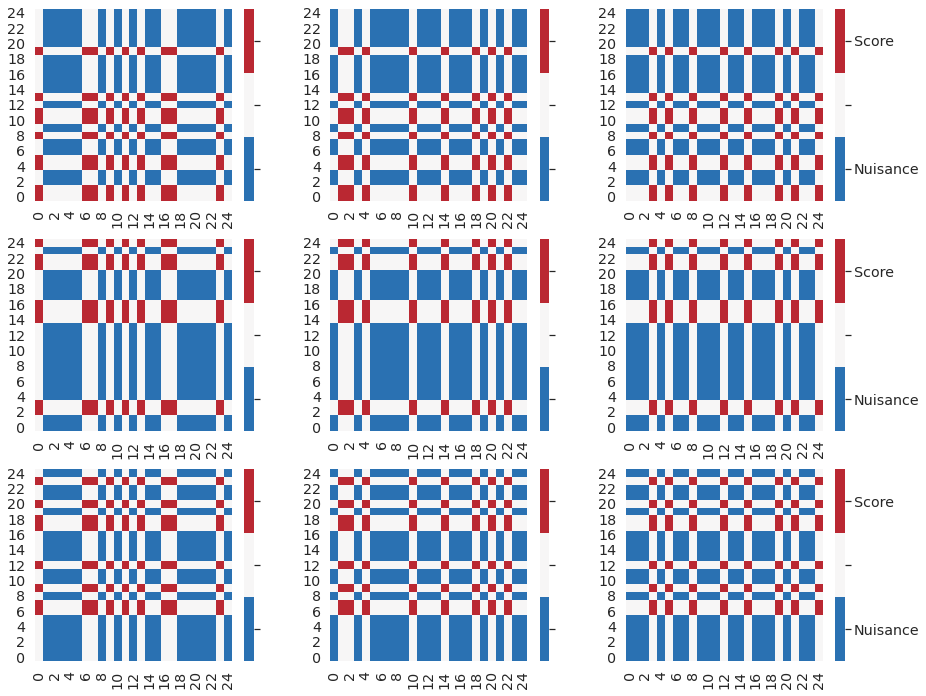

In [9]:
for i_split, this_split_ind in enumerate(smpls_multi_ind):
    plt.subplot(K, K, i_split + 1)
    df = pd.DataFrame(np.zeros([N, M]))
    ind_array_train = np.array([*this_split_ind[0]])
    ind_array_test = np.array([*this_split_ind[1]])
    df.loc[ind_array_train[:, 0], ind_array_train[:, 1]] = -1.
    df.loc[ind_array_test[:, 0], ind_array_test[:, 1]] = 1.

    ax = sns.heatmap(df, cmap=cMap);
    ax.invert_yaxis();
    ax.set_ylim([0, M]);
    colorbar = ax.collections[0].colorbar
    colorbar.set_ticks([-0.667, 0, 0.667])
    if i_split % K == (K - 1):
        colorbar.set_ticklabels(['Nuisance', '', 'Score'])
    else:
        colorbar.set_ticklabels(['', '', ''])

### Visualize sample splitting with linear indexing (one column per fold)



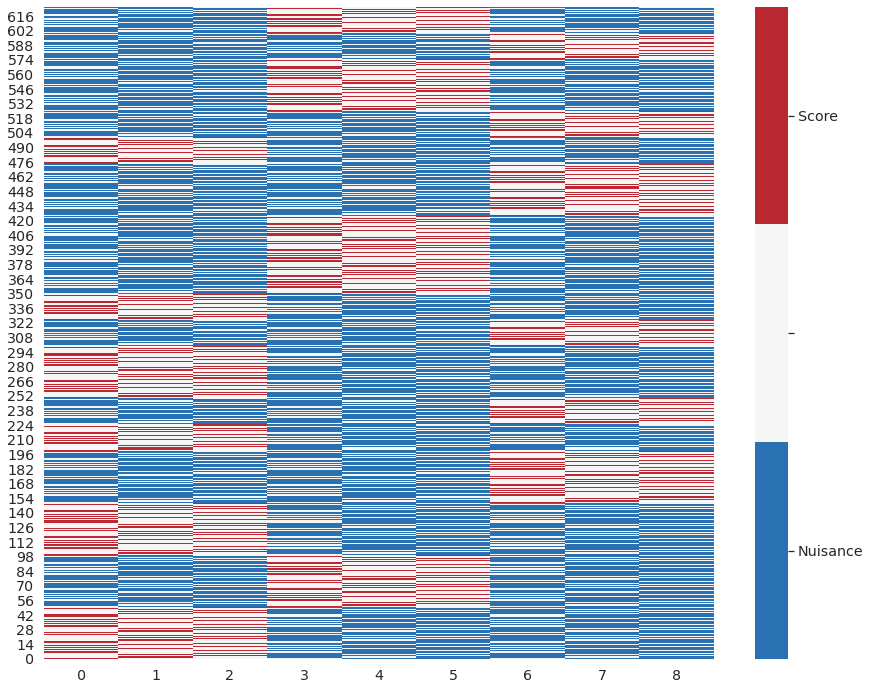

In [10]:
df = pd.DataFrame(np.zeros([N*M, K*K]))
for i_split, this_split_ind in enumerate(smpls_lin_ind):
    df.loc[this_split_ind[0], i_split] = -1.
    df.loc[this_split_ind[1], i_split] = 1.

ax = sns.heatmap(df, cmap=cMap);
ax.invert_yaxis();
ax.set_ylim([0, N*M]);
colorbar = ax.collections[0].colorbar
colorbar.set_ticks([-0.667, 0, 0.667])
colorbar.set_ticklabels(['Nuisance', '', 'Score'])